# User behavior anomaly detection for cybersecurity

In [5]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install gensim -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import of ds frameworks

import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import joblib
import pickle
from tqdm import tqdm_notebook

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential, Model
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization, LeakyReLU, ReLU
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import optuna

import re
from gensim.models import Word2Vec

In [8]:
# Dependencies setup

RAND = 100

from numpy.random import seed
seed(RAND)

import random
random.seed(RAND)

from tensorflow import random
tf.random.set_seed(RAND)

import os
os.environ["PYTHONHASHSEED"] = str(RAND)
os.environ["TF_DETERMINISTIC_OPS"] = '1'
os.environ["TF_CUDNN_DETERMINISTIC"] = '1'

tf.config.experimental.enable_op_determinism()

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

## Task description

This progect demonstates the application of an autoencoder neural network for monitoring user activity on a file repository. The goal is to detect unusual behavior that may indicate a security threat, thereby helping to prevent data breaches.

The model is trained to identify anomalies based on patterns in user activity logs. Anomalies could be complex and sophisticated, however, key markers of anomalous behaviour include: 

- access from an uknown IP adress 
- performing a new type of operations (e.g., a user who never deletes files suddenly does so)
- accessing files with unusual or atypical topics
- unusual activity during off-hours, such as evenings or weekends
- a critical number of 'access denied' errors in a short period

### Data description

The initial dataset is a user's log activity, including features

- actual_date: the day and the time of the action
- weekday
- the id of operation on a file
- used IP
-  operation success (True or False)
- filename

In [9]:
data = pd.read_csv('user_log_upd.csv', parse_dates=['actual_date'])
data.head()

,actual_date,weekday,event_type_id,actor_ip,operation_success,file_name
0,2025-04-01 10:20:07.007000,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...
1,2025-04-01 10:35:33.586000,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...
2,2025-04-01 10:35:33.586000,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...
3,2025-04-01 10:35:33.596000,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...
4,2025-04-01 10:35:33.596000,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...


## Feature engineering

### Time delta between operations

In [10]:
# calculate the difference between folowing operations in one day
data['actual_date'] = pd.to_datetime(data['actual_date'], format='mixed')
data['td_seconds'] = data['actual_date'].diff().map(lambda x : x.total_seconds())
same_day = data['actual_date'].dt.date ==  data['actual_date'].shift().dt.date
data.loc[~same_day, 'td_seconds'] = None

In [11]:
data.head()

,actual_date,weekday,event_type_id,actor_ip,operation_success,file_name,td_seconds
0,2025-04-01 10:20:07.007,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...,NaN
1,2025-04-01 10:35:33.586,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...,926.579
2,2025-04-01 10:35:33.586,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...,0.000
3,2025-04-01 10:35:33.596,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...,0.010
4,2025-04-01 10:35:33.596,2,30,192.168.128.7,True,{subject_name=S:ShareФинансыУправленческий уче...,0.000


### Filename to vector 

In [12]:
# filename extraction from file_name column
def filename(s):
    match = re.search(r'object_name=([^,]+)', s)
    if match:
        return match.group(1)
    else:
        return None

In [13]:
def tokenization(text):
    tokens = re.split(r'(?<=[а-яёАЯЁa-zA-z])(?=[А-ЯЁA-Z])|[\s\-\.]+', text)
    return [t for t in tokens if len(t)>1]

In [14]:
data['file_name'] = data['file_name'].apply(filename)

In [15]:
data['tokenized_titles'] = data['file_name'].apply(tokenization)

In [16]:
l_list = data['tokenized_titles'].tolist()

In [17]:
w2v = Word2Vec(l_list, vector_size=10, window=5, min_count=3, sg=1)

In [18]:
def title_to_vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)   

In [19]:
data['title_vector'] = data['tokenized_titles'].apply(lambda x: title_to_vec(tokens=x, model=w2v))

In [20]:
vector_cols = ['title_'+str(i) for i in range(10)]

In [21]:
data[vector_cols] = pd.DataFrame(data['title_vector'].tolist(), index=data.index)

In [22]:
data = data.drop(columns=['tokenized_titles'])

In [23]:
#final dataset
data.head()

,actual_date,weekday,event_type_id,actor_ip,operation_success,file_name,td_seconds,title_vector,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9
0,2025-04-01 10:20:07.007,2,30,192.168.128.7,True,S:ShareФинансыУправленческий учетБюджетыИнжене...,NaN,"[-0.26691303, 0.18921654, 0.22777228, -0.10446...",-0.266913,0.189217,0.227772,-0.104468,0.557186,-0.975918,0.316308,1.027103,-0.406869,-0.236302
1,2025-04-01 10:35:33.586,2,30,192.168.128.7,True,S:ShareФинансыУправленческий учетБюджетыАдмини...,926.579,"[-0.05674211, 0.72433925, -0.05307863, 0.14931...",-0.056742,0.724339,-0.053079,0.149319,0.039989,-0.191790,0.541617,0.656972,-0.514301,-0.061660
2,2025-04-01 10:35:33.586,2,30,192.168.128.7,True,S:ShareФинансыУправленческий учетБюджетыАдмини...,0.000,"[-0.05674211, 0.72433925, -0.05307863, 0.14931...",-0.056742,0.724339,-0.053079,0.149319,0.039989,-0.191790,0.541617,0.656972,-0.514301,-0.061660
3,2025-04-01 10:35:33.596,2,30,192.168.128.7,True,S:ShareФинансыУправленческий учетБюджетыАдмини...,0.010,"[0.10645134, 0.49245098, 0.26136154, 0.0868656...",0.106451,0.492451,0.261362,0.086866,-0.162667,0.046055,0.579088,0.811342,-0.450559,-0.147755
4,2025-04-01 10:35:33.596,2,30,192.168.128.7,True,S:ShareФинансыУправленческий учетБюджетыАдмини...,0.000,"[0.1586593, 0.506368, 0.2295448, 0.046688445, ...",0.158659,0.506368,0.229545,0.046688,-0.121137,0.079224,0.576438,0.854516,-0.448303,-0.141471


## EDA

### Time series visualization

In [24]:
timeseries = pd.DataFrame()
timeseries['datetime'] = data['actual_date'].dt.floor('T')
timeseries['success'] = data['operation_success']

data = data.set_index('actual_date')

In [25]:
agg_timeseries = timeseries.groupby('datetime')['success'].count().to_frame(name='count')

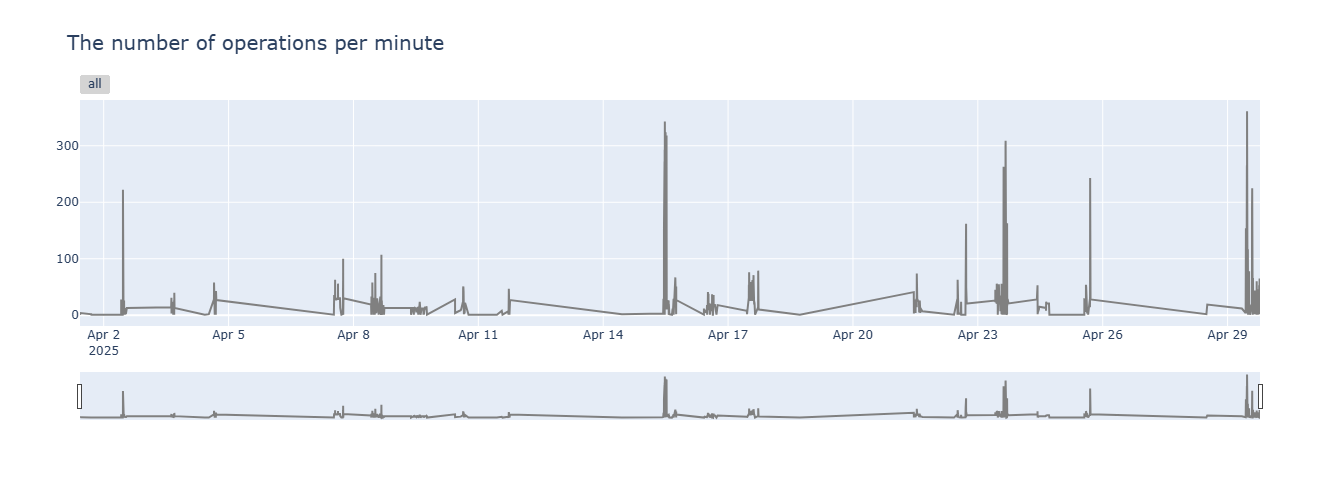

In [26]:
layout = go.Layout(
    autosize=False,
    width=1100,
    height=500,
    title={'text': f'The number of operations per minute', 'font': dict(size=20)})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=agg_timeseries.index, y=agg_timeseries['count'], mode='lines', line=dict(color='grey')))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
    buttons= list([
    dict(step = 'all')])))

<div class="alert alert-block alert-info">
The user actively uses the repository (almost every workday). The peak usage can reach up to 300 operations per minute.
</div>

### Train-test split

In [27]:
train_dates = ['2025-04-01', '2025-04-29']
test_dates = ['2025-04-29', '2025-04-30']

In [28]:
mask_train = (data.index > train_dates[0]) & (data.index < train_dates[1])
mask_test = (data.index > test_dates[0]) & (data.index < test_dates[1])
train = data[mask_train].dropna()
test = data[mask_test]

In [29]:
test = test[~test.index.duplicated(keep='first')]

In [30]:
data_train = agg_timeseries[(agg_timeseries.index > train_dates[0]) & (agg_timeseries.index < train_dates[1])]
data_test = agg_timeseries[(agg_timeseries.index > test_dates[0]) & (agg_timeseries.index < test_dates[1])]

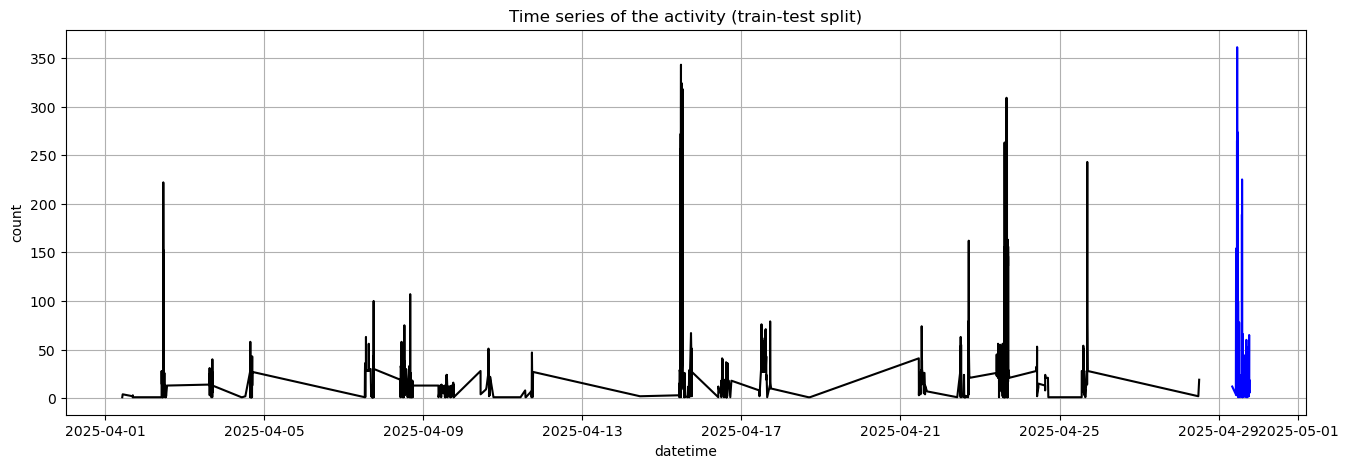

In [31]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot()

sns.lineplot(data=data_train, x=data_train.index, y='count', color="black")
sns.lineplot(data=data_test, x=data_test.index, y='count', color="blue")

plt.title('Time series of the activity (train-test split)')

plt.grid()

<div class="alert alert-block alert-info">

The activity on the test day (2025-04-29), characterized by several peaks in operations per minute, closely resembles the pattern seen on certain training days, notably 2025-04-15 and 2025-04-23.

</div>

### Looking for anomalies in the test data

#### Analysis of proceeded operations

In [32]:
train_operations = pd.DataFrame(round(train['event_type_id'].value_counts()/train.shape[0]*100, 2))
test_operations = pd.DataFrame(round(test['event_type_id'].value_counts()/test.shape[0]*100, 2))

In [33]:
operations = pd.merge(train_operations, test_operations, on='event_type_id', how='outer', suffixes=('_train', '_test'))

In [34]:
operations

,count_train,count_test
event_type_id,,
28,NaN,0.04
29,NaN,0.01
30,100.0,99.32
33,NaN,0.22
34,NaN,0.40
35,NaN,0.01


<div class="alert alert-block alert-info">
The distribution of operations remains lagerly unchanged from the training to the test periods. Operation type 30 (read) is predominant, accounting for 99% of all activity.
</div>

<div class="alert alert-block alert-danger">
ANOMALY: The test dataset contains several new operation types, accounting for 0.68% of test day activity (28 - create, 29 - delete, 33 - write, 34 - rename, 35 - remove)
</div>

#### The change in time delta between operations

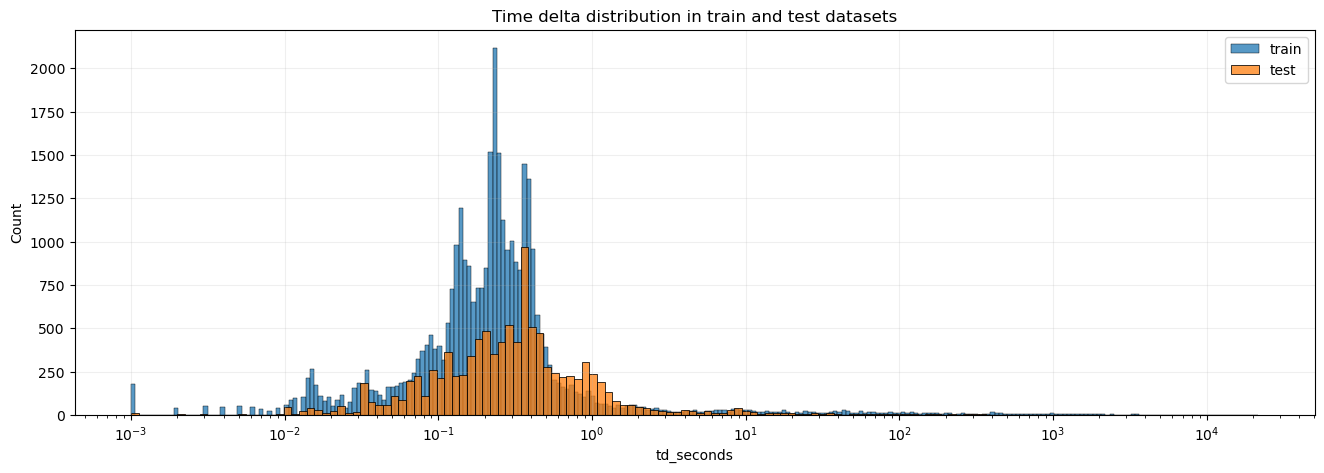

In [35]:
fig = plt.figure(figsize=(16, 5))
plt.grid(alpha=0.2)

sns.histplot(data=train, x='td_seconds', log_scale=True, label='train')
sns.histplot(data=test, x='td_seconds', log_scale=True, label='test')

plt.legend()

plt.title('Time delta distribution in train and test datasets')
plt.show()

In [36]:
train.td_seconds.describe()

count    35499.000000
mean        11.664148
std        227.052639
min          0.000000
25%          0.122000
50%          0.225000
75%          0.359000
max      21754.036000
Name: td_seconds, dtype: float64

In [37]:
test.td_seconds.describe()

count    10409.000000
mean         3.610014
std         78.955172
min          0.001000
25%          0.148000
50%          0.303000
75%          0.519000
max       5744.586000
Name: td_seconds, dtype: float64

<div class="alert alert-block alert-info">
The distribution of time intervals between operations remains mainly unchanged between the training and the test periods, with 50 percentiles 0.225 and 0.3 in train and test datasets.
</div>

#### New ip address

In [38]:
print(f'The number of unique IPs in train = {train.actor_ip.nunique()}')
print(f'The number of unique IPs in test = {test.actor_ip.nunique()}')
print(f'The number of new IPs in test = {len(set(pd.Series(list(set(test.actor_ip) - set(train.actor_ip))).dropna())) }')
print(f'New IP в test = {set(pd.Series(list(set(test.actor_ip) - set(train.actor_ip))).dropna())}')

The number of unique IPs in train = 1
The number of unique IPs in test = 2
The number of new IPs in test = 1
New IP в test = {'10.200.10.121'}


In [39]:
round(test['actor_ip'].value_counts()/test.shape[0]*100, 2)

actor_ip
192.168.128.7    97.95
10.200.10.121     2.05
Name: count, dtype: float64

<div class="alert alert-block alert-danger">
ANOMALY: A new IP address appears in the test dataset, responsible for 2% of daily activity.
</div>

#### Unussual documents' topics

In [40]:
def cosine(x, y):
     return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))

In [41]:
train_typical_doc = np.array(train[vector_cols].mean().tolist())

In [42]:
test['cos_similarity'] = test.apply(lambda x: cosine(x['title_vector'], train_typical_doc), axis=1)

In [43]:
test['cos_similarity'].astype(float).describe()

count    10410.000000
mean         0.868983
std          0.109992
min          0.662539
25%          0.770299
50%          0.857148
75%          0.987393
max          0.991406
Name: cos_similarity, dtype: float64

<div class="alert alert-block alert-info">
The  test dataset shows strong topic alignment with the training data. The minimum cosine similarity between filenames and the training period's typical filename (average vector) is 0.67, while over 25% of the test files are highly tematically similar to the typical training file.
</div>

## Data transformation to tensors

In [44]:
# the length of sequence of batched operations
seq_length = 3

### Encoding of categorical features

In [45]:
def label_encoder(train, test, cols):

    """
    Encoding of categorical features
    """

    dicts = []
    train_label = train.copy(deep=True)
    test_label = test.copy(deep=True)

    for i, col in enumerate(cols):
        le = LabelEncoder()

        #df = train[~train[col].isnull()]
        df_train = train.copy(deep=True)
        df_train[col] = le.fit_transform(df_train[col])+1
    
        globals()["label_mapping_" + str(i)] = dict(zip(le.classes_, range(1,len(le.classes_)+1)))
        label_dict = globals()["label_mapping_" + str(i)]
        
        new_data = set(test[col])-set(train[col])

        for e in new_data:
            if e in label_dict or pd.isnull(e):
                continue
            else:
                label_dict[e] = len(label_dict.keys())+1

        train_label[col] = train[col].map(label_dict).fillna(0).astype(int)  
        test_label[col] = test[col].map(label_dict).fillna(0).astype(int)

        dicts.append(label_dict)

    return train_label, test_label, dicts      

### Tensor

In [46]:
def tensor_seq(sequence_length, data):
    
    """
    Creation of tensor of sequences with 1 operation lag
    """
    
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data.iloc[i:i+sequence_length].values)
    sequences = np.array(sequences)
    tensor = tf.convert_to_tensor(sequences, dtype=tf.float32)

    return tensor

In [47]:
def preprocessing(data, train_dates, test_dates, seq_lenght):
    """
    step1 - train/test split
    step2 - label encoding
    step3 - normalization
    step4 - creation tensor of sequences
    """

    # train-test split
    mask_train = (data.index >= train_dates[0]) & (data.index <= train_dates[1])
    mask_test = (data.index >= test_dates[0]) & (data.index <= test_dates[1])
    train = data[mask_train].dropna().drop(columns=['file_name', 'title_vector'])
    test = data[mask_test].drop(columns=['file_name', 'title_vector'])

    # encoding
    train_label, test_label, label_keys = label_encoder(train, test, 
                                                        ['event_type_id',
                                                         'actor_ip', 'operation_success'])
    # normalization
    scaler = MinMaxScaler()
    train_scaled = pd.DataFrame()
    test_scaled = pd.DataFrame()
    train_scaled[train_label.columns] = scaler.fit_transform(train_label)
    test_scaled[test_label.columns] = scaler.transform(test_label)

    # tensors
    train_tensor = tensor_seq(seq_length, train_scaled)
    test_tensor = tensor_seq(seq_length, test_scaled)

    print("Training dataset shape:", train_tensor.shape)
    print("Test dataset shape:", test_tensor.shape)

    return train, test, test_scaled, train_tensor, test_tensor, label_keys

In [48]:
train, test, test_scaled, train_tensor, test_tensor, label_keys = preprocessing(data, train_dates, test_dates, seq_length)

I0000 00:00:1764063789.510337     965 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Training dataset shape: (35497, 3, 15)
Test dataset shape: (10503, 3, 15)


In [49]:
# the example of a test tensor
test_tensor[25]

<tf.Tensor: shape=(3, 15), dtype=float32, numpy=
array([[2.5000000e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.8726592e-06, 5.6483829e-01, 3.8993338e-01, 4.6519664e-01,
        5.9960920e-01, 7.4350893e-02, 3.8809404e-01, 3.3968255e-01,
        7.5397980e-01, 5.6832451e-01, 4.0483215e-01],
       [2.5000000e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.8266907e-06, 5.6247008e-01, 3.9662966e-01, 4.6252331e-01,
        5.9845680e-01, 6.9932617e-02, 3.9042404e-01, 3.3409268e-01,
        7.5420409e-01, 5.6807297e-01, 3.9727333e-01],
       [2.5000000e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        7.7227050e-06, 2.0002052e-01, 2.2403653e-01, 5.9452021e-01,
        1.2800373e-01, 0.0000000e+00, 5.3781825e-01, 3.1066141e-01,
        7.7144825e-01, 6.3711137e-05, 9.0673918e-01]], dtype=float32)>

## Autoencoder neural network

### Model architecture

In [50]:
def encoder(inputs, params):
    x = inputs
    for i in range(params.get('n_hidden_layers')):
        x = Dense(params.get('max_dim')//2**i, activation=None, name=f'encoder_dense_{i}')(x)
        x = BatchNormalization()(x)
        #x = ReLU()(x)
        x = LeakyReLU(params.get('relu_cof'))(x)
        x = Dropout(params.get('dropout_cof'))(x)
        
    # final bottleneck layer
    x = Dense(params.get('latent_dim'), activation=None, name='bottleneck')(x)
    
    return x

In [51]:
def decoder(encoder, X, params):
    x = encoder
    for i in range(params.get('n_hidden_layers')):
        x = Dense(params.get('max_dim')//2**(params.get('n_hidden_layers')-i-1), activation=None, name=f'decoder_dense_{i}')(x)
        x = BatchNormalization()(x)
        #x = ReLU()(x)
        x = LeakyReLU(params.get('relu_cof'))(x)
        x = Dropout(params.get('dropout_cof'))(x)
    
    # output
    x = Dense(X.shape[2], activation=None)(x)
    
    return x

In [52]:
def dense_autoencoder(X, params):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    encoder_output = encoder(inputs, params)
    decoder_output = decoder(encoder_output, X, params)
    
    model = Model(inputs=inputs, outputs=decoder_output)
    
    model.compile(
        optimizer=Adam(learning_rate=params.get('learning_rate')),
        loss='mse')
    #model.summary()

    return model

In [53]:
def plot_loss(history):

    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mse)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

### Hyperparameters' setup

In [411]:
def objective(trial, train_tensor):

    max_dim = trial.suggest_int('max_dim', 12, 18, 2)
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 2, 3, 1)
    latent_dim = trial.suggest_int('latent_dim', 2, 4, 1)
    relu_cof = trial.suggest_float('relu_cof', 0, 0.2)
    dropout_cof = trial.suggest_float('dropout_cof', 0, 0.05)

    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [20, 50, 100, 200])
    
 
    params = dict()
    params['max_dim'] = max_dim
    params['n_hidden_layers'] = n_hidden_layers
    params['relu_cof'] = relu_cof
    params['dropout_cof'] = dropout_cof
    params['latent_dim'] = latent_dim
    params['learning_rate'] = learning_rate

    ae_model = dense_autoencoder(train_tensor, params)

    early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=True,
    patience=12,
    restore_best_weights=True
)

    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    verbose=True,
    patience=3,
    factor= 0.0001,
    min_lr = 1e-7
)

    history = ae_model.fit(
        train_tensor,
        train_tensor,
        batch_size=batch_size,
        epochs=50,
        verbose=0,
        callbacks = [early_stopping, reduce_lr],
        shuffle=False, validation_split=0.2
        ).history

    return history['val_loss'][-1]    

In [456]:
study = optuna.create_study(direction='minimize')

func = lambda trial: objective(trial, train_tensor)
study.optimize(func, n_trials=10, show_progress_bar=True)

[I 2025-11-21 15:39:22,112] A new study created in memory with name: no-name-9ad05974-c03a-444e-9bdb-0a890cadf61f


  0%|          | 0/10 [00:00<?, ?it/s]

2025-11-21 15:39:22.188976: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 8: ReduceLROnPlateau reducing learning rate to 9.291552938520909e-07.

Epoch 11: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 5.
[I 2025-11-21 15:40:05,800] Trial 0 finished with value: 0.014317342080175877 and parameters: {'max_dim': 18, 'n_hidden_layers': 2, 'latent_dim': 2, 'relu_cof': 0.09115084077967456, 'dropout_cof': 0.042503898117238786, 'learning_rate': 0.00929155324662952, 'batch_size': 50}. Best is trial 0 with value: 0.014317342080175877.


2025-11-21 15:40:05.893881: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 4: ReduceLROnPlateau reducing learning rate to 9.813372045755387e-06.

Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 1.
[I 2025-11-21 15:40:19,495] Trial 1 finished with value: 0.014734749682247639 and parameters: {'max_dim': 14, 'n_hidden_layers': 3, 'latent_dim': 3, 'relu_cof': 0.1077850083376349, 'dropout_cof': 0.015848272079896482, 'learning_rate': 0.09813372215862622, 'batch_size': 200}. Best is trial 0 with value: 0.014317342080175877.


2025-11-21 15:40:19.570732: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-11-21 15:40:27.008642: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 13: ReduceLROnPlateau reducing learning rate to 2.7936142869293693e-07.

Epoch 16: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 10.
[I 2025-11-21 15:42:33,810] Trial 2 finished with value: 0.010374654084444046 and parameters: {'max_dim': 14, 'n_hidden_layers': 2, 'latent_dim': 4, 'relu_cof': 0.04194615750984376, 'dropout_cof': 0.009871414346169572, 'learning_rate': 0.0027936143728531596, 'batch_size': 20}. Best is trial 2 with value: 0.010374654084444046.


2025-11-21 15:42:33.888255: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 10: ReduceLROnPlateau reducing learning rate to 4.164096340537072e-06.

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 7.
[I 2025-11-21 15:43:22,396] Trial 3 finished with value: 0.02946142479777336 and parameters: {'max_dim': 16, 'n_hidden_layers': 2, 'latent_dim': 3, 'relu_cof': 0.04266320313641499, 'dropout_cof': 0.043687890830006966, 'learning_rate': 0.041640962442739966, 'batch_size': 50}. Best is trial 2 with value: 0.010374654084444046.


2025-11-21 15:43:22.471182: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-11-21 15:43:29.801635: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 7: ReduceLROnPlateau reducing learning rate to 4.899997264146805e-07.

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 10.
[I 2025-11-21 15:45:35,679] Trial 4 finished with value: 0.01408300455659628 and parameters: {'max_dim': 12, 'n_hidden_layers': 2, 'latent_dim': 3, 'relu_cof': 0.05684882706398873, 'dropout_cof': 0.0028119746194128215, 'learning_rate': 0.004899997091837589, 'batch_size': 20}. Best is trial 2 with value: 0.010374654084444046.


2025-11-21 15:45:35.771104: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-11-21 15:45:41.185164: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.784635733813047e-07.

Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 2.
[I 2025-11-21 15:46:23,603] Trial 5 finished with value: 0.014962973073124886 and parameters: {'max_dim': 12, 'n_hidden_layers': 3, 'latent_dim': 2, 'relu_cof': 0.10861759703653745, 'dropout_cof': 0.01923036872001939, 'learning_rate': 0.004784635688424557, 'batch_size': 50}. Best is trial 2 with value: 0.010374654084444046.


2025-11-21 15:46:23.692406: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-11-21 15:46:30.183084: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 7: ReduceLROnPlateau reducing learning rate to 5.476681515574456e-07.

Epoch 10: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 4.
[I 2025-11-21 15:47:19,649] Trial 6 finished with value: 0.01463558990508318 and parameters: {'max_dim': 16, 'n_hidden_layers': 3, 'latent_dim': 4, 'relu_cof': 0.06616297287615318, 'dropout_cof': 0.039664468290684755, 'learning_rate': 0.005476681390086202, 'batch_size': 50}. Best is trial 2 with value: 0.010374654084444046.


2025-11-21 15:47:19.744513: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 5: ReduceLROnPlateau reducing learning rate to 6.692693382501602e-06.

Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 2.
[I 2025-11-21 15:47:45,828] Trial 7 finished with value: 0.02295645885169506 and parameters: {'max_dim': 12, 'n_hidden_layers': 3, 'latent_dim': 4, 'relu_cof': 0.12456730340154638, 'dropout_cof': 0.012593740270853034, 'learning_rate': 0.06692693041872595, 'batch_size': 100}. Best is trial 2 with value: 0.010374654084444046.


2025-11-21 15:47:45.904869: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.2372303754091262e-07.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1e-07.
Restoring model weights from the end of the best epoch: 48.
[I 2025-11-21 15:49:51,825] Trial 8 finished with value: 0.013017536140978336 and parameters: {'max_dim': 14, 'n_hidden_layers': 2, 'latent_dim': 4, 'relu_cof': 0.045518663941308594, 'dropout_cof': 0.025913610886655482, 'learning_rate': 0.0012372303242903725, 'batch_size': 50}. Best is trial 2 with value: 0.010374654084444046.


2025-11-21 15:49:51.918264: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 19: ReduceLROnPlateau reducing learning rate to 1.826783991418779e-07.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 32.
[I 2025-11-21 15:51:06,872] Trial 9 finished with value: 0.0153067447245121 and parameters: {'max_dim': 14, 'n_hidden_layers': 3, 'latent_dim': 3, 'relu_cof': 0.05927199270013124, 'dropout_cof': 0.010175533438993646, 'learning_rate': 0.0018267839832526295, 'batch_size': 100}. Best is trial 2 with value: 0.010374654084444046.


In [457]:
print("Best params:", study.best_params)

Best params: {'max_dim': 14, 'n_hidden_layers': 2, 'latent_dim': 4, 'relu_cof': 0.04194615750984376, 'dropout_cof': 0.009871414346169572, 'learning_rate': 0.0027936143728531596, 'batch_size': 20}


In [458]:
params = dict()
params['max_dim'] = study.best_params.get('max_dim')
params['n_hidden_layers'] = study.best_params.get('n_hidden_layers')
params['relu_cof'] = study.best_params.get('relu_cof')
params['dropout_cof'] = study.best_params.get('dropout_cof')
params['latent_dim'] = study.best_params.get('latent_dim')
params['learning_rate'] = study.best_params.get('learning_rate')

In [58]:
params = dict()
params['max_dim'] = 16
params['n_hidden_layers'] = 2
params['relu_cof'] = 0.14
params['dropout_cof'] = 0.03
params['latent_dim'] = 4
params['learning_rate'] = 0.0025

### Training

In [59]:
ae_model = dense_autoencoder(train_tensor, params)

In [60]:
EPOCHS = 50
BATCH_SIZE = 256

In [61]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=True,
    patience=12,
    restore_best_weights=True
)

In [62]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    verbose=True,
    patience=3,
    factor= 0.0001,
    min_lr = 1e-7
)

In [63]:
history = ae_model.fit(
    train_tensor,
    train_tensor,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks = [early_stopping, reduce_lr],
    shuffle=False, validation_split=0.2
).history

2025-11-25 09:43:50.190043: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 25: ReduceLROnPlateau reducing learning rate to 2.4999999441206456e-07.

Epoch 28: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 22.


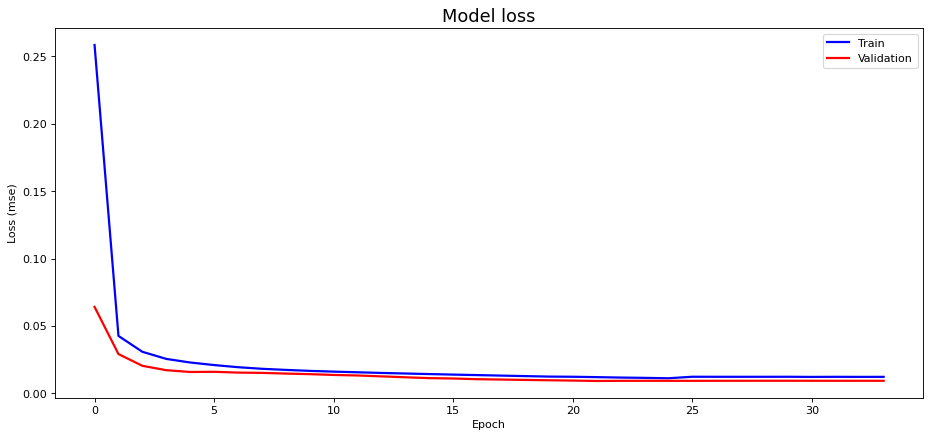

In [64]:
plot_loss(history)

In [65]:
threshold = np.max(history['val_loss'])
threshold

np.float64(0.06407617777585983)

## Anomaly detection

In [66]:
def predict(model, seq_lenght, tensor, df_scaled, df, threshold):

    """
    model - autoencoder model
    tensor - tensor of sequences
    df_scaled - датасет с нормированными признаками
    df - исходный датасет (test)

    """

    # create a dataframe with prediction col
    test_pred = model.predict(tensor)
    test_pred_2d = tf.unstack(test_pred, axis=1)[-1]
    pred_df = pd.DataFrame(test_pred_2d, columns=df.columns)
    pred_df.index = df.index[(seq_lenght-1):]


    # calculate difference between prediction and the actual value
    df_metrics = pd.DataFrame(index=pred_df.index)

    df_scaled = df_scaled[(seq_lenght-1):]
    df_scaled.index = df_metrics.index
    
    df_metrics['MAE'] = np.mean(np.abs(pred_df-df_scaled), axis=1)

    # threshold setup
    #df_metrics['Threshold_loss'] = (threshold**0.5)*1.15
    df_metrics['Threshold_loss'] = 0.325

    df_metrics['Anomaly'] = np.where(df_metrics['MAE'] > df_metrics['Threshold_loss'], 1, 0)

    df_a = df[(seq_lenght-1):].copy(deep=True)
    
    df_a['MAE'] = df_metrics['MAE']
    df_a['Threshold'] = df_metrics['Threshold_loss']
    df_a['Anomaly'] = df_metrics['Anomaly']

    return df_a

In [67]:
import pickle
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [68]:
test_anomaly = predict(loaded_model, seq_length, test_tensor, test_scaled, test, threshold)

151/329 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step

2025-11-25 09:44:26.637734: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


### Test day anomaies breakdown

Previously, it was mentioned that there are two anomaly markers for the user - a new IP and several new operation types. 

In [69]:
print(f'Percent of anomalies within the test day = {round(test_anomaly[test_anomaly.Anomaly==1].shape[0]/test_anomaly.shape[0]*100,0)} %')

Percent of anomalies within the test day = 2.0 %


In [72]:
anomaly_frame = test_anomaly.groupby(['actor_ip', 'Anomaly'])['event_type_id'].count().to_frame(name='count')
anomaly_frame

,,count
actor_ip,Anomaly,
10.200.10.121,1,214
192.168.128.7,0,10289


In [73]:
test_anomaly.groupby(['actor_ip', 'event_type_id', 'Anomaly'])['event_type_id'].count().to_frame(name='count')

count
actor_ip      event_type_id Anomaly       
10.200.10.121 28            1            4
              29            1            1
              30            1          143
              33            1           23
              34            1           42
              35            1            1
192.168.128.7 30            0        10289

<div class="alert alert-block alert-success"> 
    
- On the test day, all events flagged as anomalous (2% of the total) came from a new IP address. The model correctly classified all 214 events from a new IP as anomolous.
    
- For operation types, the new IP generated events with entirely new operation types, which were completely unfolded by the model.

</div>

### Analysis of anomalies

#### Reconstruction error

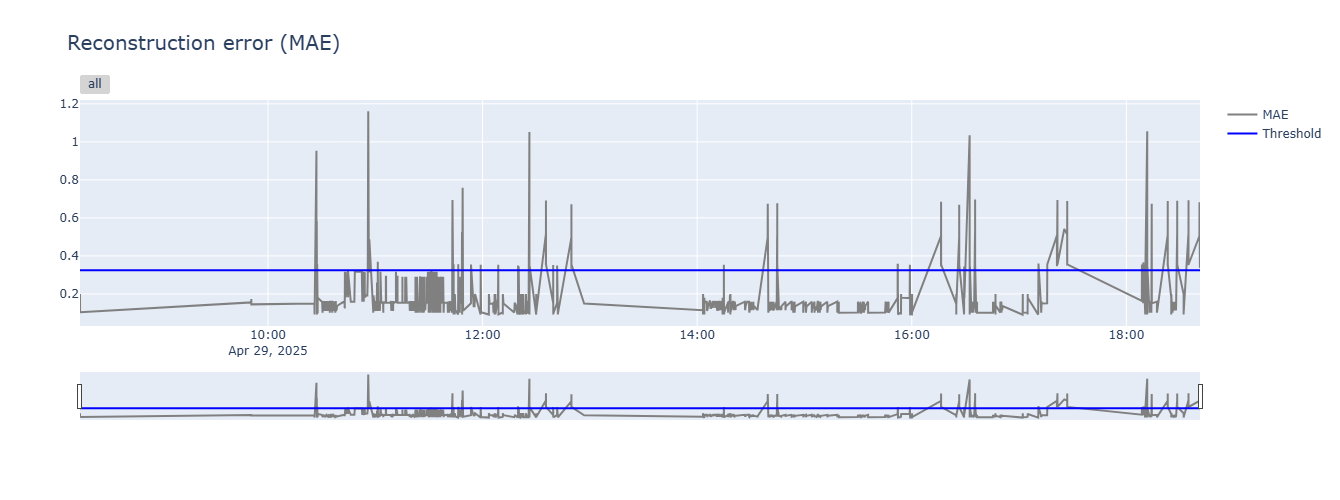

In [74]:
layout = go.Layout(
autosize=False,
width=1100,
height=500,
title={'text': f'Reconstruction error (MAE)', 'font': dict(size=20)})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=test_anomaly.index, y=test_anomaly['MAE'], mode='lines', line=dict(color='grey'), name=f"MAE"))
fig.add_trace(go.Scatter(x=test_anomaly.index, y=test_anomaly['Threshold'], mode='lines', line=dict(color='blue'), name=f"Threshold"))

fig.update_xaxes(
     rangeslider_visible=True,
     rangeselector = dict(
     buttons= list([
     dict(step = 'all')])))

<div class="alert alert-block alert-success"> 
    
- On the reconstruction error graph, the threshold line segregates normal and anomalous events. The peaks above the threshold line indicate anomalies.
    
- These prominent peaks indicating significant discrepancies between predicted and actual tensor values. This means that the autoencoder could not repeat the given tensors and they were eventually flagged as anomalies. The substantial magnitude of peaks in the reconstruction error for anomalies demonstrates the model's high prediction confidence.

</div>

#### Metrics

Since the anomalous markers are defined from EDA analisys (new IP addresses and new operation types), we can compute standard prediction quality metrics. This evaluate the model's coverage - how effectively it detects these known anomalous patterns.

In [75]:
def anomaly_get(data, level0, level1):
    try:
        return data.loc[(level0, level1)]
    except KeyError:
        return 0

In [76]:
def result_metrics(train, test_anomaly, marker):

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    train_ips = train[marker].unique()
    
    test_anomaly = test_anomaly[['event_type_id', 'actor_ip', 'td_seconds', 'MAE', 'Threshold', 'Anomaly']]
    anomaly_frame = test_anomaly.groupby([marker, 'Anomaly'])['event_type_id'].count().to_frame(name='count')

    test_ips = anomaly_frame.index.get_level_values(0).unique()

    for test_ip in test_ips:
        if test_ip in train_ips:
            
            tn += anomaly_get(anomaly_frame, test_ip, 0)
            fp += anomaly_get(anomaly_frame, test_ip, 1)

        else:
            tp += anomaly_get(anomaly_frame, test_ip, 1)
            fn += anomaly_get(anomaly_frame, test_ip, 0)

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)

    metrics_dict = {'precision': precision,
                    'recall': recall,
                    'f1': f1}
    

    return metrics_dict

In [77]:
ips_metrics = pd.DataFrame(result_metrics(train, test_anomaly, 'actor_ip'))

In [78]:
operation_metrics = pd.DataFrame(result_metrics(train, test_anomaly, 'event_type_id'))

In [79]:
ips_metrics.rename(index={'count': 'ip_anomalies'})

,precision,recall,f1
ip_anomalies,1.0,1.0,1.0


In [80]:
operation_metrics.rename(index={'count': 'operation_anomalies'})

,precision,recall,f1
operation_anomalies,0.331776,1.0,0.498246


<div class="alert alert-block alert-success"> 
    
- Overall, the model detects 100% of events from new IPs and 100% of events with new operation types
- High recall is targeted to control Type II errors (false negatives), which is critical for security to prevent missed threats. Meanwhile, high precision is sought to control Type I errors (false positives), reducing alert fatigue and ensuring that triggered alarms are trustworthy.
- For the sronger signal of IP anomalies, the model achieves the highest metrics (precision=1, recall=1): all detected alerts are genuinely suspicious

</div>

#### Anomalies on a timeline

In [102]:
mask = (agg_timeseries.index >= test_dates[0]) & (agg_timeseries.index < test_dates[1])
test_agg = agg_timeseries[mask].rename(columns={'count':'all_events'})

In [103]:
anomalies = test_anomaly[test_anomaly.Anomaly==1].copy(deep=True).reset_index()
anomalies['actual_date'] = anomalies['actual_date'].dt.floor('T')

In [104]:
anomalies_agg = anomalies.groupby('actual_date')['operation_success'].count().to_frame(name='anomalies')

In [105]:
test_anomaly_count = pd.merge(test_agg, anomalies_agg, left_index=True, right_index=True, how='left').fillna(0)

In [106]:
test_anomaly_count['percent_anomalies'] = round(test_anomaly_count['anomalies'] / test_anomaly_count['all_events'],2)

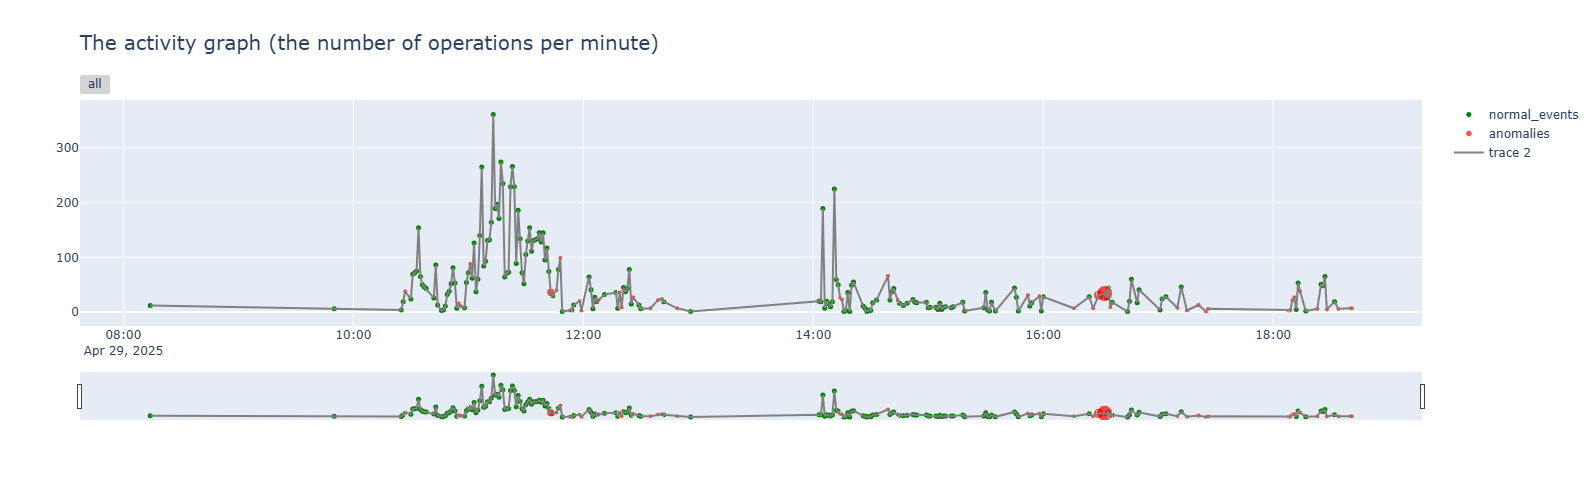

In [107]:
layout = go.Layout(
autosize=False,
width=1100,
height=500,
title={'text': f'The activity graph (the number of operations per minute)', 'font': dict(size=20)})

fig = go.Figure(layout=layout)

out = test_anomaly_count[test_anomaly_count['anomalies']>0]
norm = test_anomaly_count[test_anomaly_count['anomalies']==0]

fig.add_trace(go.Scatter(x=norm.index, y=norm['all_events'], mode='markers', marker=dict(color='green', size=5), name=f"normal_events"))

fig.add_trace(go.Scatter(x=out.index, y=out['all_events'], mode='markers',
                         marker=dict(color='red', 
                         #opacity = test_anomaly_count['percent_anomalies'],
                         size=test_anomaly_count['percent_anomalies']*15+5),
                         name=f"anomalies"))

fig.add_trace(go.Scatter(x=test_agg.index, y=test_anomaly_count['all_events'], mode='lines', line=dict(color='grey')))

fig.update_xaxes(
     rangeslider_visible=True,
     rangeselector = dict(
     buttons= list([
     dict(step = 'all') ])))

In [108]:
hour_anomalies = (test_anomaly[test_anomaly.Anomaly==1]).groupby(test_anomaly[test_anomaly.Anomaly==1].index.hour)['operation_success'].count().to_frame().transpose()

In [109]:
hour_events = test_anomaly.groupby(test_anomaly.index.hour)['operation_success'].count().to_frame().transpose()

In [110]:
res_hour_anomalies = ((hour_anomalies / hour_events)*100).fillna(0).rename({'operation_success': '%_anomalies_per_hour'})

Text(0.5, 1.0, 'Percentage of anomalies per working hour')

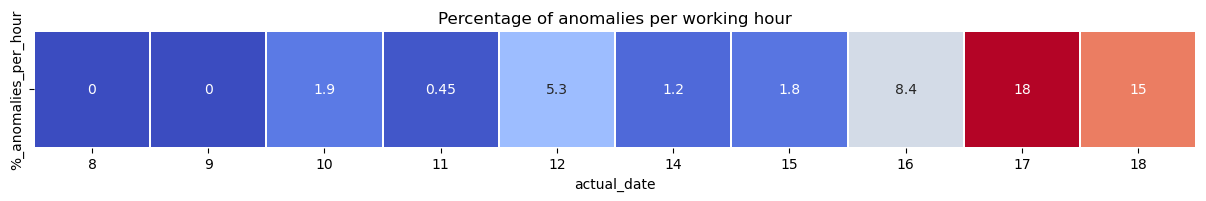

In [111]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()

sns.heatmap(res_hour_anomalies, linewidths=0.1, cmap='coolwarm', cbar=False, annot=True, square=True)
plt.title('Percentage of anomalies per working hour', fontsize=12)

<div class="alert alert-block alert-success"> 
    
On the test day, the share of anomalies increases progressively, peaking at the close of working hours. Starting with non incidents in the morning hours, it reaches 5% at midday and 18% by the end of the work day. This surge indicates the risk of threats during evenings when security systems are sensitive to attacks.

</div>

#### Filename analysis

In [112]:
test_anomaly_filename = pd.merge(test_anomaly, data.file_name, 'left', 'actual_date')

In [113]:
evening_test_anomaly_filename = test_anomaly_filename[test_anomaly_filename.index.hour >= 17]

In [114]:
print(f'The number of unique files used after 5 pm = {evening_test_anomaly_filename.file_name.nunique()}')

The number of unique files used after 5 pm = 55


In [94]:
title_cols = [col for col in evening_test_anomaly_filename.columns if col.startswith('title_')]
evening_test_anomaly_filename['title_vec'] = evening_test_anomaly_filename[title_cols].values.tolist()

In [95]:
filename_dataset = evening_test_anomaly_filename[['title_vec', 'file_name']]

In [96]:
cosine_sim = filename_dataset.drop_duplicates(subset=['file_name'])

In [97]:
vector_array = np.array(cosine_sim.title_vec.tolist())

In [98]:
from sklearn.metrics.pairwise import cosine_similarity

In [99]:
cosine_sim_matrix = cosine_similarity(vector_array)

In [100]:
cosine_df = pd.DataFrame(cosine_sim_matrix)

<Axes: >

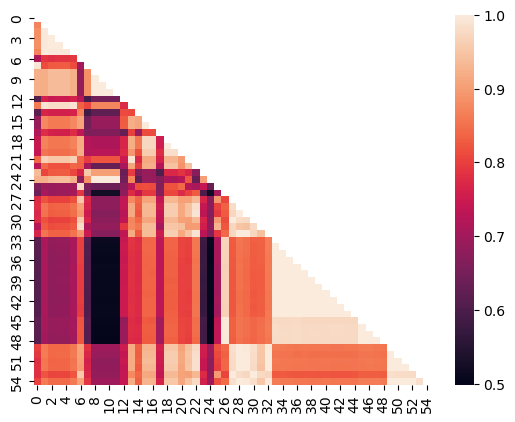

In [101]:
mask = np.triu(np.ones_like(cosine_df, dtype=bool))
sns.heatmap(cosine_df,
           mask = mask,
           fmt = '.3f')

<div class="alert alert-block alert-success"> 
    
During the high-risk period (after 5 pm), the user was interacting with 55 unique files. Crucially, the semantic analysis of the files' topics revealed low cosine similarity scores (0.5-0.6) for some files. This finding validates the model's alerts and points to true detection suspicious behavior of the user.

</div>

# Summary

<div class="alert alert-block alert-success"> 
    
This project has established a machine learning pipeline for the detection of suspicious user activity on a file repository.

- EDA pinpointed unknown IPs, new file operation types and filenames dissimilarity as primary anomaly indicators.
- User activity was transformed into a temporal sequence tensor, with shape = (3,15), encoding the categorical features for model consumption.
- An autoencoder neural network with a bottleneck (16-8-4-8-16) was developed. The use of Batch Normalization and LeakyReLU activations ensured stable and efficient training. The model's hyperparameters were tuned using an Optuna study.
- The model's anomaly detection mechanism, based on reconstruction error, proved accurate. On the test day, the model achieved a precision of 1 (no false positives) and a recall of 1, indicating it caught all true anomalies (events from unknown IP and new operation-type).
- The analysis of detected anomalies provides actionable intelligence, showing a peak in suspicious activity during the evening hours (5-6 PM), involving interaction with atypical documents.

</div>